# Face Generation

In this project, I defined and trained a DCGAN on a dataset of faces. My goal was to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, we'll be able to visualize the results of our trained Generator to see how it performs; our generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

I'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train my adversarial networks.

This dataset is complex, and so, I defined deeper network and trained it for a longer time to get good results.

### Pre-processed Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images.

In [ ]:

!unzip processed_celeba_small.zip


In [5]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

In [6]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [7]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])
    trainset = datasets.ImageFolder(data_dir,transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
    
    return trainloader


## Create a DataLoader

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [8]:
# Define function hyperparameters
batch_size = 64
img_size = 32

# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

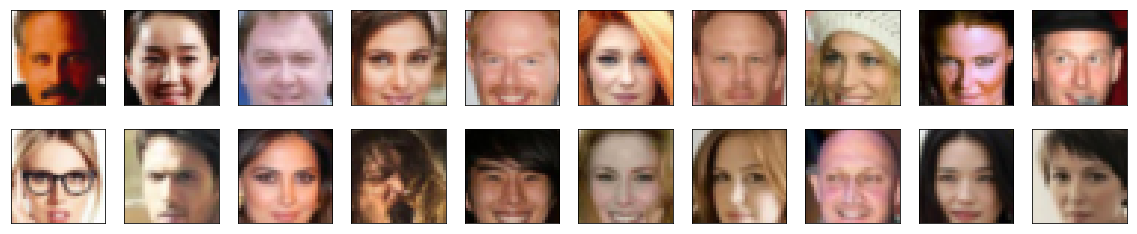

In [9]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Pre-process your image data and scale it to a pixel range of -1 to 1

We need to do a bit of pre-processing; the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [10]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = x*2*feature_range[1]+feature_range[0]
    
    return x


In [11]:

# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

The first task will be to define the discriminator. This is a convolutional classifier only without any maxpooling layers. To deal with this complex data, it's suggested to use a deep network with **normalization**.

#### Define Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
def conv(in_channels,out_channels,kernel_size=4,stride=2,padding=1,batch_norm=False):
    layers = []
    conv_layer = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [14]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        # complete init function
        self.conv1 = conv(3,conv_dim)
        self.conv2 = conv(conv_dim,conv_dim*2,batch_norm=True)
        self.conv3 = conv(conv_dim*2,conv_dim*4,batch_norm=True)
        self.conv4 = conv(conv_dim*4,conv_dim*8,batch_norm=True)
        
        
        self.fc1   = nn.Linear(conv_dim*8*2*2,1)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.leaky_relu(self.conv2(x),0.2)
        x = F.leaky_relu(self.conv3(x),0.2)
        x = F.leaky_relu(self.conv4(x),0.2)
    
        
        x = x.view(-1,self.conv_dim*8*2*2)
        x = self.fc1(x)
        x = self.dropout(x)
        return x



tests.test_discriminator(Discriminator)

Tests Passed


In [15]:
def deconv(in_channels,out_channels,kernel_size=4,stride=2,padding=1,batch_norm=False):
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding)
    layers.append(deconv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Define the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [16]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.fc1 = nn.Linear(z_size,conv_dim*8*2*2)
        self.deconv1 = deconv(conv_dim*8,conv_dim*4)
        self.deconv2 = deconv(conv_dim*4,conv_dim*2)
        self.deconv3 = deconv(conv_dim*2,conv_dim)
        self.deconv4 = deconv(conv_dim,3)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc1(x)
        x = x.view(-1,self.conv_dim*8,2,2)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.tanh(self.deconv4(x))
        return x

tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help our models converge, we should initialize the weights of the convolutional and linear layers in our model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.



#### Define the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [17]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         m.weight.data.normal_(1.0, 0.02)
#         m.bias.data.fill_(0)
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    

## Build complete network

Define the models' hyperparameters and instantiate the discriminator and generator from the classes defined above.

In [18]:

def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [19]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(in_features=1024, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=1024, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (deconv2): Sequential(


### Training on GPU

Check if we can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`.
>
* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [20]:

import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.



In [21]:
def real_loss(D_out,smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size  = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size  = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [23]:
import torch.optim as optim
lr = 0.0002
beta1 = 0.3
beta2 = 0.5
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),lr,[beta1,beta2])
g_optimizer = optim.Adam(G.parameters(),lr,[beta1,beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator.

#### Saving Samples

some code to print out some loss statistics and save some generated "fake" samples has been predefined

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [24]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()
        
    G.train()
    D.train()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            d_real = D.forward(real_images)
            d_real_loss = real_loss(d_real,smooth=True)
            z = np.random.uniform(-1,1,size=(batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G.forward(z)
            d_fake  = D.forward(fake_images)
            d_fake_loss = fake_loss(d_fake)
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1,1,size=(batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G.forward(z)
            d_fake  = D.forward(fake_images)
            g_loss = real_loss(d_fake)
            
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [25]:
# set number of epochs 
n_epochs = 35


# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   35] | d_loss: 1.3054 | g_loss: 1.4086
Epoch [    1/   35] | d_loss: 0.5917 | g_loss: 4.9934
Epoch [    1/   35] | d_loss: 0.6531 | g_loss: 5.6094
Epoch [    1/   35] | d_loss: 0.6789 | g_loss: 6.0343
Epoch [    1/   35] | d_loss: 0.6461 | g_loss: 6.8474
Epoch [    1/   35] | d_loss: 0.7221 | g_loss: 6.7969
Epoch [    1/   35] | d_loss: 0.6518 | g_loss: 7.0586
Epoch [    1/   35] | d_loss: 0.6251 | g_loss: 6.4998
Epoch [    1/   35] | d_loss: 0.6798 | g_loss: 7.0826
Epoch [    1/   35] | d_loss: 0.6236 | g_loss: 6.6526
Epoch [    1/   35] | d_loss: 0.6389 | g_loss: 6.9901
Epoch [    1/   35] | d_loss: 0.6746 | g_loss: 5.6481
Epoch [    1/   35] | d_loss: 0.6840 | g_loss: 6.7033
Epoch [    1/   35] | d_loss: 0.6795 | g_loss: 7.7369
Epoch [    1/   35] | d_loss: 0.6347 | g_loss: 7.4888
Epoch [    1/   35] | d_loss: 0.7178 | g_loss: 8.2462
Epoch [    1/   35] | d_loss: 0.6737 | g_loss: 6.8396
Epoch [    1/   35] | d_loss: 0.6415 | g_loss: 4.6031
Epoch [    1/   35] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

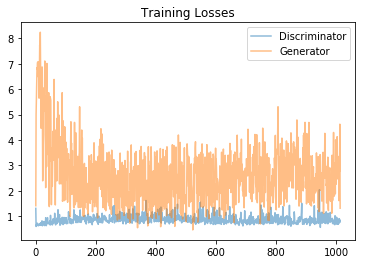

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator

In [27]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [28]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

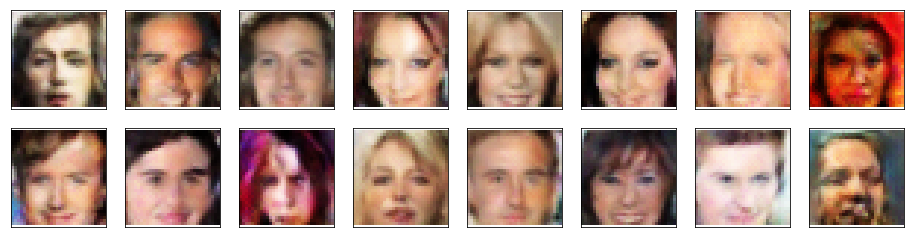

In [29]:
_ = view_samples(-1, samples)